## Next step, couple the flow and CO2 transport solvers. First, rewrite water and air flow solvers as functions.

In [1]:
%pylab inline
from crossSection import CrossSection
from ShapeGen import genCirc
from numpy.random import rand,seed

Populating the interactive namespace from numpy and matplotlib


In [67]:
array()
Q = 0.15
nx = 6
xs =linspace(0,500,nx)
zs = linspace(0,1,nx)
seed(5)
rs = 0.1 + rand(nx-1)#*ones(nx-1)
slopes = (zs[1:] - zs[:-1])/(xs[1:] - xs[:-1])
Ls = xs[1:]- xs[:-1]
fd_mids = zeros(nx-1)
f=0.1
#Generate cross-sections
xcs = []
maxdepths = []
for r in rs:
    x, y = genCirc(r)
    xc = CrossSection(x,y)
    xcs.append(xc)
    maxdepths.append(xc.ymax-xc.ymin)
    
#Calculate flow depths
h = zeros(nx)
for i, xc in enumerate(xcs):
    #Try calculating flow depth
    fd = xc.calcNormalFlowDepth(Q,slopes[i],f=f)
    backflooded= (h[i]-zs[i+1])>maxdepths[i]
    if fd==-1:
        over_normal_capacity=True
    else:
        over_normal_capacity=False
        
    if over_normal_capacity or backflooded:
        print('Pipe ',i,' is full')
        if i==0:
            #if downstream boundary set head to top of pipe
            h[0]=maxdepths[0]
        #We have a full pipe, calculate head gradient instead
        delh = xc.calcPipeFullHeadGrad(Q,slopes[i],f=f)
        h[i+1] = h[i] + delh * (xs[i+1] - xs[i])
        fd_mids[i] = xc.ymax - xc.ymin
    else:
        crit_fd = xc.calcCritFlowDepth(Q)
        y_star = min([crit_fd,fd])
        y_out = h[i] - zs[i]
        downstream_critical = y_star>y_out and y_star>0# and i>0
        partial_backflood = fd < h[i] - zs[i+1]
        downstream_less_normal = fd>y_out
        if partial_backflood: #upstream node is flooded above normal depth
            print('Pipe ',i,' is partially backflooded.')
            y_in = xc.calcUpstreamHead(Q,slopes[i],y_out,Ls[i],f=f)
            h[i+1] = zs[i+1] + y_in
            fd_mids[i] = (y_out + y_in)/2.
        elif downstream_critical:
            print('Pipe ',i,' is downstream critical.')
            #Use minimum of critical or normal depth for downstream y
            print(y_star)
            y_in = xc.calcUpstreamHead(Q,slopes[i],y_star,Ls[i],f=f)
            fd_mids[i] = (y_in + y_star)/2.
            h[i+1] = zs[i+1] + y_in
            if i==0:
                h[0]=y_star
        elif downstream_less_normal:
            print('Pipe ',i,'is downstream less than normal depth.')
            y_in = xc.calcUpstreamHead(Q,slopes[i],y_out,Ls[i],f=f)
            h[i+1] = zs[i+1] + y_in
            fd_mids[i] = (y_out+y_in)/2.
        else:
            print('Pipe ',i,' is normal')
            print('fd',fd, '  ystar=',y_star)
            if i==0:
                h[i] = fd + zs[i]
            #dz = slopes[i]*(x[i+1] - x[i])
            h[i+1] = zs[i+1] + fd
            fd_mids[i] = fd

#########
## Airflow solver
#########

T_ext = 273+20.
T_cave = 273+10.
dH=50.
rho_air_cave = 1.225#lg/m^3 @ 15 C
g=9.8
dP_tot = rho_air_cave*g*dH*(T_ext-T_cave)/T_ext

D_H_air = zeros(nx-1)
A_air = zeros(nx-1)
R_air = zeros(nx-1)
for i, xc in enumerate(xcs):
    dryidx = xc.y>fd_mids[i]
    A_air[i] = xc.calcA(wantidx=dryidx)
    P_dry = xc.calcP(wantidx=dryidx)
    if A_air[i]>0:
        D_H_air[i] = 4.*A_air[i]/P_dry
        R_air[i] = rho_air_cave*f*Ls[i]/(2.*D_H_air[i]*A_air[i]**2.)
    else:
        R_air[i] = np.inf
Q_air = np.sqrt(abs(dP_tot/R_air.sum()))*np.sign(dP_tot)
print("Air discharge = ",Q_air, ' m^3/s')            


Pipe  0  is downstream critical.
0.160556903765672
Pipe  1  is partially backflooded.
Pipe  2  is full
Pipe  3  is partially backflooded.
Pipe  4  is normal
fd 0.11532812965920515   ystar= 0.01875248763089675
Air discharge =  0.0  m^3/s


In [77]:
ft = zeros(10,dtype=object)
ft

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

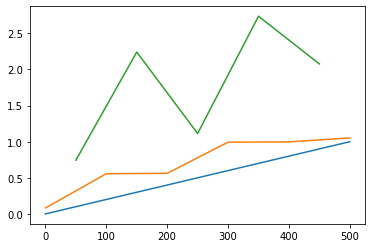

In [33]:
plot(xs,zs,xs,h)
xmid = (xs[1:] + xs[:-1])/2.
plot(xmid,maxdepths+(zs[1:] + zs[:-1])/2.)

In [34]:
fd_mids

array([0.21950975, 0.25936287, 0.27782704, 0.29554665, 0.05261643])

0.0970731108579833 0.8384384339356487 0.4237570732172906
0.11472276737761662 0.9093051140906359 0.46228044350977215
0.13237242389724996 0.9733744927367315 0.4978404776259081
0.15002208041688328 1.0308894083486235 0.5304371755656997
0.1676717369365166 1.0871708370288942 0.563033873505491
0.18532139345614992 1.1372087367581842 0.5926672352689386
0.20297104997578325 1.1812827717194203 0.6193372608560405
0.2206207064954166 1.2291426628175381 0.6489706226194872
0.2382703630150499 1.2711786626535972 0.6756406482065895
0.25592001953468324 1.3076902572385536 0.6993473376173469
0.27356967605431654 1.347775424629692 0.726017363204449
0.2912193325739499 1.3825013564953839 0.7497240526152067
0.30886898909358323 1.4163523201533859 0.7734307420259645
0.32651864561321653 1.4493068917426206 0.7971374314367218
0.3441683021328499 1.4773903881221646 0.8178807846711349
0.3618179586524832 1.5086084652560472 0.8415874740818922
0.3794676151721165 1.5351417482229102 0.8623308273163051
0.3971172716917499 1.560

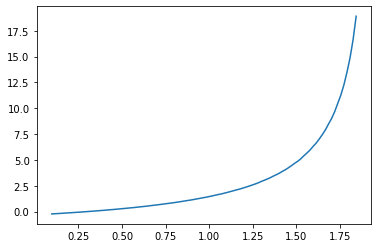

In [18]:
#xcs[1].calcCritFlowDepth(0.3)

maxdepth = xcs[1].ymax - xcs[1].ymin
depths = linspace(0.05*maxdepth,0.95*maxdepth,100)
res = zeros(100)

for i,depth in enumerate(depths):
    res[i] = xcs[1].crit_flow_depth_residual(depth,1.75)
plot(depths, res)

In [19]:
res

array([-2.21743090e-01, -2.03855704e-01, -1.85737542e-01, -1.67726263e-01,
       -1.48325472e-01, -1.29440375e-01, -1.11392736e-01, -9.01317285e-02,
       -6.98721134e-02, -5.09384577e-02, -2.85620198e-02, -7.68329359e-03,
        1.41577696e-02,  3.69936194e-02,  5.78179348e-02,  8.26129358e-02,
        1.05208443e-01,  1.28671880e-01,  1.56586110e-01,  1.82005792e-01,
        2.04557761e-01,  2.31788153e-01,  2.60041546e-01,  2.89353741e-01,
        3.15349596e-01,  3.46729140e-01,  3.74556421e-01,  4.03271208e-01,
        4.37931312e-01,  4.68667700e-01,  5.00385464e-01,  5.33116999e-01,
        5.72630292e-01,  6.07676419e-01,  6.43848739e-01,  6.81186141e-01,
        7.19729282e-01,  7.59520690e-01,  8.00604856e-01,  8.35862734e-01,
        8.79439479e-01,  9.24446692e-01,  9.70937460e-01,  1.01896742e+00,
        1.06859492e+00,  1.11121555e+00,  1.16393297e+00,  1.21842930e+00,
        1.27477478e+00,  1.33304320e+00,  1.38311484e+00,  1.44511272e+00,
        1.50926397e+00,  

In [11]:
ds = linspace(1e-6,xcs[0].ymax-xcs[0].ymin,100)
Q = zeros(100)
for i,y in enumerate(ds):
    Q[i] = xcs[0].calcNormalFlow(y,0.002)

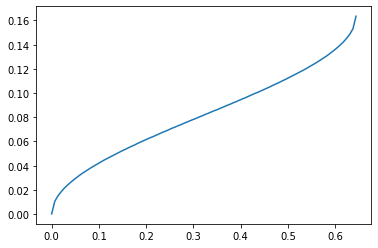

In [12]:
plot(ds,Q)

In [13]:
xcs[0].ymax-xcs[0].ymin

0.643985547690147

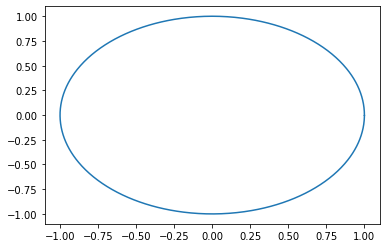

In [69]:
plot(x,y)

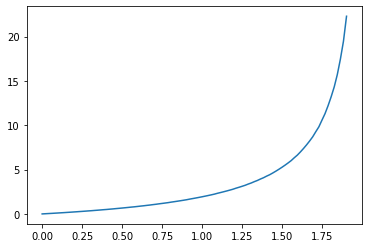

In [68]:
x, y = genCirc(1.,d=1000)
xc = CrossSection(x,y)
maxdepth = xc.ymax - xc.ymin
depths = linspace(0.0005*maxdepth,0.95*maxdepth,100)
res = zeros(100)

for i,depth in enumerate(depths):
    res[i] = xc.crit_flow_depth_residual(depth,0.25)
plot(depths, res)    

In [16]:
res

array([-5.33356826e-03,  1.43322428e-02,  3.46574067e-02,  5.40686441e-02,
        7.48261934e-02,  9.59005619e-02,  1.17992850e-01,  1.38860476e-01,
        1.61577229e-01,  1.84084458e-01,  2.08262029e-01,  2.31744321e-01,
        2.56710739e-01,  2.80495001e-01,  3.05569122e-01,  3.31978985e-01,
        3.56615173e-01,  3.85683832e-01,  4.12767951e-01,  4.41066637e-01,
        4.70623075e-01,  4.97552515e-01,  5.29592209e-01,  5.58770245e-01,
        5.93471042e-01,  6.25061541e-01,  6.57838842e-01,  6.91844481e-01,
        7.27121981e-01,  7.63717133e-01,  7.96169476e-01,  8.35340935e-01,
        8.75973870e-01,  9.12007169e-01,  9.55503216e-01,  9.94078355e-01,
        1.04064731e+00,  1.08195273e+00,  1.13182508e+00,  1.17606807e+00,
        1.22174251e+00,  1.26889924e+00,  1.32586001e+00,  1.37641423e+00,
        1.42862795e+00,  1.48256278e+00,  1.53828326e+00,  1.59585707e+00,
        1.66546380e+00,  1.72730140e+00,  1.79122946e+00,  1.85733081e+00,
        1.92569252e+00,  